# AR Sliding Window

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.api import OLS, add_constant
from scipy.stats import shapiro, anderson
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from scipy import stats 
from statsmodels.stats.stattools import durbin_watson
import pmdarima as pm
from itertools import product
from itertools import product
from tqdm import tqdm 
from joblib import Parallel, delayed

In [4]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet with Original Data.xlsx')
# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

In [5]:
df_exog = pd.read_excel('data/All Exogenous Variables.xlsx')
# Ensure date is datetime and set index
df_exog['Month'] = pd.to_datetime(df_exog['Month'])
df_exog.set_index('Month', inplace=True)
df_exog.index = pd.date_range(start=df_exog.index[0], periods=len(df_exog), freq='MS')
df_exog.columns = df_exog.columns.str.strip()

In [6]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP', 'IM', 'EX', 'CC']

In [7]:
windows = [
    ('2017-09-01', '2020-02-01'),
    ('2020-03-01', '2022-08-01'),
    ('2022-09-01', '2025-01-01')
]

In [37]:
def run_model(macro, exog, window):
    start_date, end_date = pd.to_datetime(window[0]), pd.to_datetime(window[1])

    # Select y series and exog window
    y = df[macro].loc[start_date:end_date].dropna().asfreq('MS')
    exog = df_exog[exog].dropna().asfreq('MS')
    exog_window = exog.loc[start_date:end_date].dropna().asfreq('MS')

    # Align
    y, exog_window = y.align(exog_window, join='inner')

    # Train-test split
    split_idx = int(len(y) * 0.8)
    train, test = y[:split_idx], y[split_idx:]
    exog_train, exog_test = exog_window[:split_idx], exog_window[split_idx:]

    # AR model
    model_ar = pm.auto_arima(
        train,
        start_p=1, start_q=0,
        max_p=5, max_q=5,
        m=6,
        seasonal=True,
        stepwise=True,
        suppress_warnings=True
    )
    forecast_ar, conf_int_ar = model_ar.predict(n_periods=len(test), return_conf_int=True)

    # ARX model
    model_arx = pm.auto_arima(
        train,
        exogenous=exog_train,
        seasonal=True,
        m=6,
        start_p=1, start_q=0,
        max_p=3, max_q=5,
        max_P=2, max_Q=2,
        stepwise=True,
        trace=True,
        suppress_warnings=True
    )
    forecast_arx = model_arx.predict(n_periods=len(test), exogenous=exog_test)

    # Print orders
    print("AR Order:", model_ar.order, "Seasonal:", model_ar.seasonal_order)
    print("ARX Order:", model_arx.order, "Seasonal:", model_arx.seasonal_order)

    print("\n=== AR Model Summary ===")
    print(model_ar.arima_res_.summary())
    print("\n=== ARX Model Summary ===")
    print(model_arx.arima_res_.summary())

    # Plot 1: Full window with both forecasts
    plt.figure(figsize=(10, 5))
    plt.plot(y.index, y, label='Actual', color='black')
    plt.plot(test.index, forecast_ar, label='AR Forecast', linestyle='--', color='red')
    plt.plot(test.index, forecast_arx, label='ARX Forecast', linestyle='--', color='blue')
    plt.fill_between(test.index, conf_int_ar[:, 0], conf_int_ar[:, 1], color='pink', alpha=0.2, label='AR CI')
    plt.axvline(x=test.index[0], color='gray', linestyle=':', label='Train/Test Split')
    plt.title(f'Full Window Forecast: {macro}')
    plt.xlabel('Date')
    plt.ylabel(macro)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: Zoomed in on test period
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test, label='Actual', marker='o', color='black')
    plt.plot(test.index, forecast_ar, label='AR Forecast', linestyle='--', marker='x', color='red')
    plt.plot(test.index, forecast_arx, label='ARX Forecast', linestyle='--', marker='^', color='blue')
    plt.fill_between(test.index, conf_int_ar[:, 0], conf_int_ar[:, 1], color='pink', alpha=0.2, label='AR CI')
    plt.title(f'Test Period: {macro} Forecast Comparison')
    plt.xlabel('Date')
    plt.ylabel(macro)
    plt.legend()
    plt.tight_layout()
    plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,1,0)(1,0,1)[6] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=45.625, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=43.512, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=52.850, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=41.708, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[6] intercept   : AIC=43.593, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[6] intercept   : AIC=40.123, Time=0.04 sec
 ARIMA(2,1,0)(1,0,0)[6] intercept   : AIC=41.855, Time=0.07 sec
 ARIMA(2,1,0)(0,0,1)[6] intercept   : AIC=41.982, Time=0.05 sec
 ARIMA(2,1,0)(1,0,1)[6] intercept   : AIC=43.080, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[6] intercept   : AIC=41.967, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[6] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[6] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,0

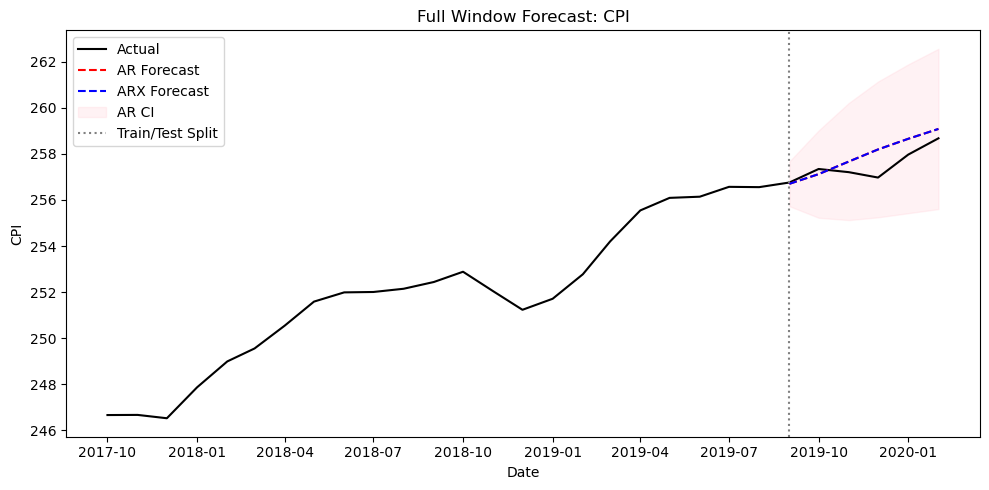

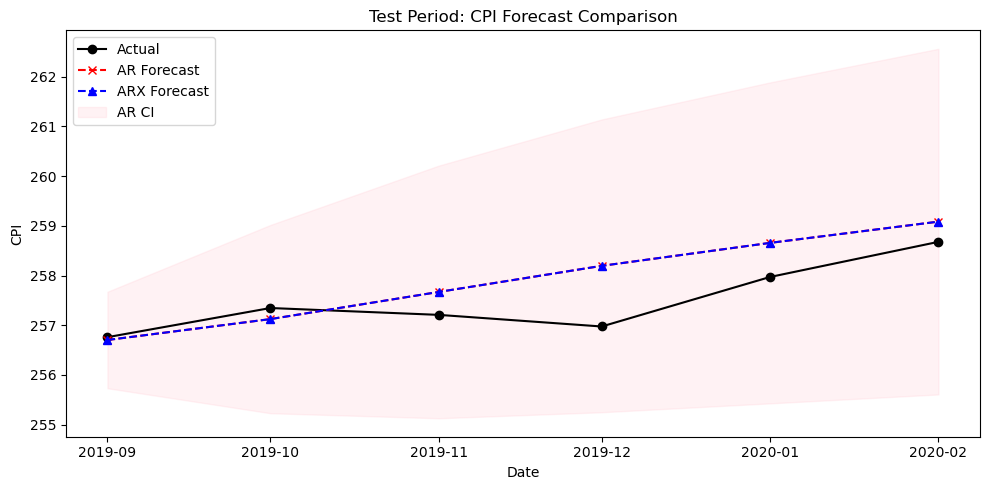

In [38]:
run_model('CPI', ['Bitcoin_lag0', 'XRP_lag1'], windows[0])

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=764.328, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=766.185, Time=0.05 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=768.163, Time=0.07 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=766.186, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=768.144, Time=0.26 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=770.160, Time=0.26 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=768.171, Time=0.09 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=770.158, Time=0.20 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=764.617, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=766.455, Time=0.25 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=768.398, Time=0.28 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=766.446, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=768.432, Time=0.25 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=770.397, Time=0.53 sec
 ARIMA(0,1,1)(

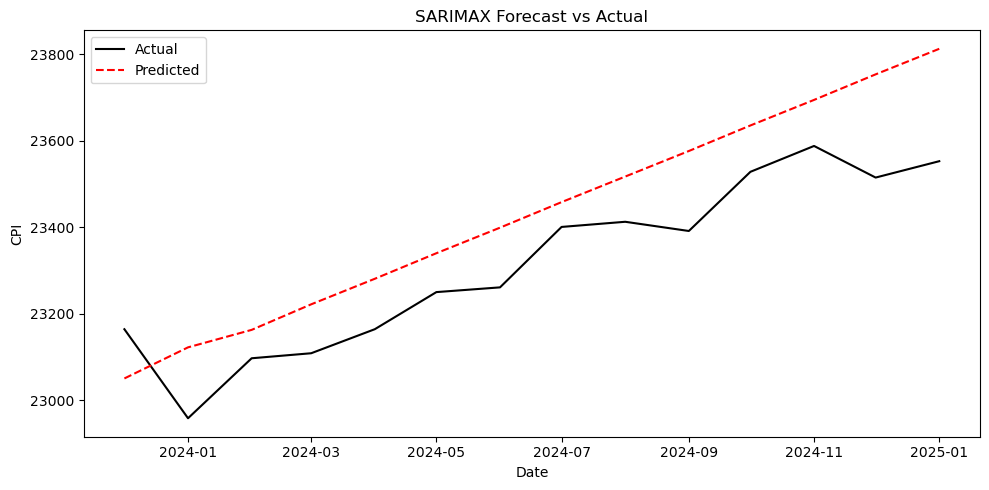

In [25]:
y = df['GDP'].dropna().asfreq('MS')
exog = df_exog.dropna().asfreq('MS')
#exog = df_exog[['XRP_lag0', 'USD Coin_lag6']].dropna().asfreq('MS')
y, exog = y.align(exog, join='inner')

split_idx = int(len(y) * 0.8)
y_train, y_test = y[:split_idx], y[split_idx:]
exog_train, exog_test = exog[:split_idx], exog[split_idx:]

model = pm.auto_arima(
    y_train,
    exogenous=exog_train,
    seasonal=True,
    m=12,
    start_p=1, start_q=0,
    max_p=3, max_d=3, max_q=5,
    max_P=2, max_D=1, max_Q=2,
    stepwise=False,
    trace=True,
    suppress_warnings=True
)

print(model.arima_res_.summary())
n_test = len(y_test)
forecast = model.predict(n_periods=n_test, exogenous=exog_test)

forecast_index = y_test.index
forecast_series = pd.Series(forecast, index=forecast_index)
print("Best SARIMAX Order:", model.order)
print("Best Seasonal Order:", model.seasonal_order)
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual', color='black')
plt.plot(forecast_series, label='Predicted', color='red', linestyle='--')
plt.title("SARIMAX Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
print(model.arima_res_.params)

intercept       59.063377
ma.L1           -0.141270
ma.L2           -0.446393
ma.L3           -0.377702
sigma2       92754.292855
dtype: float64


In [29]:
print(model.arima_res_.model.exog_names)

None
